In [1]:
import matplotlib.pyplot as plt
import cv2 
import pytesseract
from PIL import Image
from reportlab.lib.pagesizes import A4, letter
# Adding custom options

custom_config = r'--oem 2 --psm 12 -l fra+eng'



In [2]:
A4_int = (int(round(A4[0])), int(round(A4[1])))

In [3]:
img_path = './carte-grise-specimen.jpg'

In [4]:
fx=1
fy=1

In [5]:
# img = cv2.imread('img/test1.jpg',cv2.IMREAD_UNCHANGED)
img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# img = cv2.resize(img, (A4_int[0],A4_int[1]) ,interpolation=cv2.INTER_CUBIC)
img = cv2.resize(img, None,fx=fx,fy=fy ,interpolation=cv2.INTER_CUBIC)

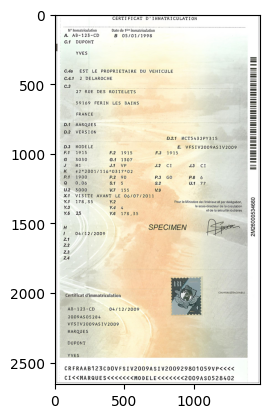

In [6]:
plt.imshow(img)

In [7]:
# cv2.imshow('image',img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [8]:
# test = pytesseract.image_to_string(Image.fromarray(img), config=custom_config)
# test

In [9]:
# Perform OCR on the RGB image using pytesseract
text = pytesseract.image_to_data(Image.fromarray(img),output_type='dict',config=custom_config)

In [10]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

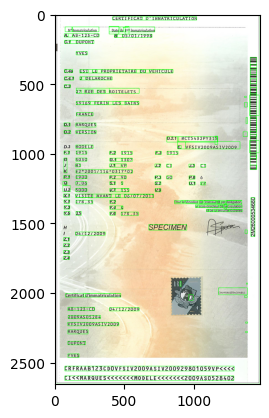

In [11]:
plt.imshow(img)

In [12]:
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i] , text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 1472 2656 
413 19 604 24 
413 19 604 24 
413 19 604 24 
413 19 214 24 CERTIFICAT
653 20 364 23 D'IbMNATRICULATION
488 92 36 3 
488 92 36 3 
488 92 36 3 
488 92 36 3 es
72 92 243 35 
72 92 243 35 
72 92 243 35 
72 92 49 35 N
125 92 190 35 Irmroadrhulotlon
388 92 328 36 
388 92 328 36 
388 92 328 36 
388 88 70 55 “Dane
466 92 24 35 do
503 88 28 55 1&%
531 92 185 36 [ramatileulstion
66 141 250 24 
66 141 250 24 
66 141 250 24 
66 141 28 24 A
124 141 192 24 AB-123-CD
426 144 270 24 
426 144 270 24 
426 144 270 24 
426 144 21 23 B
483 144 213 24 05/01/1998
68 188 211 24 
68 188 211 24 
68 188 211 24 
68 188 43 24 C.1
151 188 128 24 DUPONT
151 269 80 24 
151 269 80 24 
151 269 80 24 
151 269 80 24 YVES
67 397 60 24 
67 397 60 24 
67 397 60 24 
67 397 60 24 C.da
178 398 669 25 
178 398 669 25 
178 398 669 25 
178 398 60 23 EST
268 399 34 22 LE
332 398 251 24 PROPRIETAIRE
611 399 39 23 DU
677 399 170 24 VEHICULE
67 450 67 24 
67 450 67 24 
67 450 67 24 
67 450 67 24 C.4.1
178 450 232 23 
1

In [13]:
def adjust_text_boxes(text_data):
    # Zip the text data into tuples for easier manipulation
    boxes = list(zip([pos * A4[0] / img.shape[1] for pos in text_data['left']], 
                     [A4[1] - pos * A4[1]/img.shape[0] for pos in text_data['top']], 
                     [pos * A4[0] / img.shape[1] for pos in text_data['width']],
                       [pos * A4[1]/img.shape[0]  for pos in text_data['height']],
                         text_data['text']))

    # Sort the text boxes based on their vertical positions (top to bottom)
    sorted_boxes = sorted(boxes, key=lambda box: box[1])

    # Set a threshold for height difference to identify text on the same line
    threshold_height = 16 * A4[1]/img.shape[0]  # Adjust this value as needed
    threshold_font_size = 4
    # Correct text boxes that are too close in height
    for i in range(len(sorted_boxes) - 1):
        current_box = sorted_boxes[i]
        next_box = sorted_boxes[i + 1]

        # If the vertical distance between the current and next box is within the threshold
        if abs(current_box[1] - next_box[1]) < threshold_height:
            # Adjust the next box's top position to align it with the current box
            new_top = current_box[1]
            sorted_boxes[i + 1] = (next_box[0], new_top, next_box[2], next_box[3], next_box[4])
        if abs(current_box[3] - next_box[3]) < threshold_font_size:
                
                sorted_boxes[i + 1] = (sorted_boxes[i + 1][0], sorted_boxes[i + 1][1], sorted_boxes[i + 1][2], current_box[3], sorted_boxes[i + 1][4]) 
 

    # Unzip the corrected data
    corrected_data = {
        'left': [box[0] for box in sorted_boxes],
        'top': [box[1] for box in sorted_boxes],
        'width': [box[2] for box in sorted_boxes],
        'height': [box[3] for box in sorted_boxes],
        'text': [box[4] for box in sorted_boxes]
    }

    return corrected_data

# Example usage:
# Assuming 'text' contains the extracted text data similar to what you previously retrieved from Tesseract
corrected_text_data = adjust_text_boxes(text)

In [14]:
set(corrected_text_data["height"])

{0.9509297030642256,
 2.8527891091926767,
 6.339531353761504,
 6.973484489137654,
 7.2904610568257295,
 7.607437624513805,
 8.241390759889955,
 9.509297030642257,
 10.460226733706481,
 10.777203301394556,
 11.09417986908263,
 11.728133004458781,
 12.045109572146858,
 12.362086139834934,
 12.996039275211084,
 13.946968978275308,
 14.263945545963383,
 15.84882838440376,
 16.48278151977991,
 17.433711222844135,
 19.018594061284514,
 28.21091452423869,
 30.746727065743297,
 33.916492742624044,
 46.912532017835126,
 88.75343895266104,
 255.48311355658862,
 841.8897637795276}

In [15]:
from reportlab.pdfgen import canvas

def hello(c,left,top,text,pixel):
    c.setFont("Helvetica", pixel)
    c.drawString(left,top,text,charSpace=0.25)
c = canvas.Canvas("hello.pdf")
boxes_correct = len(corrected_text_data["left"])
for i in range(boxes ):
    if corrected_text_data["text"][i] !="": 
        (x, y, w, h,chara) = (corrected_text_data['left'][i]  ,corrected_text_data['top'][i], corrected_text_data['width'][i], corrected_text_data['height'][i],corrected_text_data["text"][i])
        hello(c,x,y,chara,h)
        # c.rect(x, y, w, h-1)
c.showPage()
c.save()

In [16]:
import sys
import cv2
import numpy as np
import pytesseract
from datetime import datetime

startTime = datetime.now()

input_image_path = sys.argv[1]

img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, None,fx=fx,fy=fy ,interpolation=cv2.INTER_CUBIC)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
invGamma = 1.0 / 0.3
table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype(
    "uint8"
)

# apply gamma correction using the lookup table
gray = cv2.LUT(gray, table)

ret, thresh1 = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY)

contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[
    -2:
]


def biggestRectangle(contours):
    biggest = True
    max_area = 0
    indexReturn = -1
    for index in range(len(contours)):
        i = contours[index]
        area = cv2.contourArea(i)
        if area > 100:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.1 * peri, True)
            if area > max_area:  # and len(approx)==4:
                biggest = approx
                max_area = area
                indexReturn = index
    return indexReturn


indexReturn = biggestRectangle(contours)
hull = cv2.convexHull(contours[indexReturn])

# create a crop mask
mask = np.zeros_like(img)  # Create mask where white is what we want, black otherwise
cv2.drawContours(mask, contours, indexReturn, 255, -1)  # Draw filled contour in mask
out = np.zeros_like(img)  # Extract out the object and place into output image
out[mask == 255] = img[mask == 255]

# crop the image
(y, x, _) = np.where(mask == 255)
(topy, topx) = (np.min(y), np.min(x))
(bottomy, bottomx) = (np.max(y), np.max(x))
out = img[topy : bottomy + 1, topx : bottomx + 1, :]

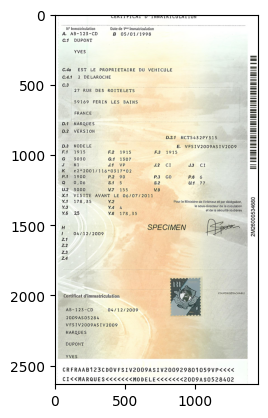

In [17]:
plt.imshow(out)

In [18]:
text = pytesseract.image_to_data(Image.fromarray(out),output_type='dict',config=custom_config)
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h,chara) = (text['left'][i] , text['top'][i], text['width'][i], text['height'][i],text["text"][i])
    print(x, y, w, h,chara)

0 0 1450 2633 
399 6 604 24 
399 6 604 24 
399 6 604 24 
399 6 214 24 CERTIFICAT
639 7 364 23 D'IbMNATRICULATION
58 79 243 35 
58 79 243 35 
58 79 243 35 
58 79 49 35 N
111 79 190 35 Irmroadrhulotlon
395 79 307 36 
374 79 328 36 
395 79 307 36 
374 79 103 35 “Dane
452 75 24 55 do
489 79 33 35 1&%
531 79 171 36 [ramatileulstion
52 128 250 24 
52 128 250 24 
52 128 250 24 
52 128 28 24 A
110 128 192 24 AB-123-CD
412 131 270 24 
412 131 270 24 
412 131 270 24 
412 131 21 23 B
469 131 213 24 05/01/1998
54 175 211 24 
54 175 211 24 
54 175 211 24 
54 175 43 24 C.1
137 175 128 24 DUPONT
137 256 80 24 
137 256 80 24 
137 256 80 24 
137 256 80 24 YVES
53 384 60 24 
53 384 60 24 
53 384 60 24 
53 384 60 24 C.da
164 385 668 25 
164 385 668 25 
164 385 668 25 
164 385 60 23 EST
254 386 34 22 LE
318 385 251 24 PROPRIETAIRE
597 386 39 23 DU
663 386 169 24 VEHICULE
53 438 67 23 
53 438 67 23 
53 438 67 23 
53 438 67 23 C.4.1
165 437 231 23 
165 437 231 23 
165 437 231 23 
165 438 13 21 2
206 437 190

In [19]:
boxes = len(text['level'])
for i in range(boxes ):
    (x, y, w, h) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i])
    #Draw box        
    cv2.rectangle(out, (x, y), (x + w, y + h), (0, 255, 0), 2)

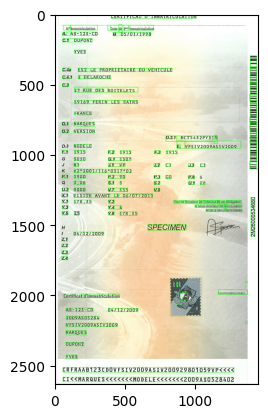

In [20]:
plt.imshow(out)

In [21]:
import re
merge_x = 20
merge_y = 10
liste_d2 = []
for i in range(boxes):
    (x, y, w, h, chara) = (text['left'][i], text['top'][i], text['width'][i], text['height'][i], text["text"][i])

    # Check if the coordinates match the region of interest
    if re.search(r'^[dD0]\.2', chara) or re.search(r'^[dD0]2', chara) :
        liste_d2.append((x,y,w,h,chara))

In [22]:
liste_d2

[(50, 822, 48, 23, 'D.2')]

In [23]:

text_concat = " ".join(text["text"])
# Define the regex pattern
pattern = r'[A-Z]{2}-\d{3}-[A-Z]{2}'

# Search for the pattern in the text
match = re.search(pattern, text_concat)

# If a match is found, print the result
if match:
    print(f"N. d'immatriculation  : {match.group()}")


# Define the regex pattern for the date
date_pattern = r'\b\d{2}/\d{2}/\d{4}\b'

# Find all occurrences of the date pattern in the text
date_matches = re.findall(date_pattern, text_concat)

# Print the list of matches
print(f"Date de 1er immarticulation : {date_matches[0]}")
print(f"Visite avant le  : {date_matches[1]}")
print(f"Date d'immarticulation actuelle  : {date_matches[2]}")

N. d'immatriculation  : AB-123-CD
Date de 1er immarticulation : 05/01/1998
Visite avant le  : 06/07/2011
Date d'immarticulation actuelle  : 04/12/2009
